In [ ]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from scipy import stats
import numpy as np

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 10, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 2, 'Number of coarsened graphs.')

# Directories.
#flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(100, corners=False)   #### why 75 here?
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del A


##############################################
features = np.loadtxt(open("../braindata/Y_rho_03.csv", "rb"), delimiter=",", skiprows=0)
features = features.transpose()
features = stats.zscore(features)
print(features.shape)

#y = np.loadtxt(open("../braindata/dx2.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))
y = np.loadtxt(open("../braindata/dx3.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))

print(y.shape)

## select the y label and the indices (excluding NaNs)
y = y[3,:] #1: dx.1ad.2mci.3smi; 2:dx2.1adonly.2adwithsmallvv.3mci.4smi; 3:pureAD1_smi0; 4:pureAD1_MCI0;5:MCI1_smi0;6:pureAD1_MCIandSMI0
ind_num=np.isnan(y)
y = y[~ind_num]
features = features[~ind_num,:]
print(features.shape)


##############################################

#features = np.loadtxt(open("../final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
#features = np.loadtxt(open("../final_data_2.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,91) )
#features = features.transpose()
#features = stats.zscore(features)
#y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
#y = np.loadtxt(open("../all_data_2.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,91))

#y = y[0,:]

bin_ixs = []
train_ixs = []
 
skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(features, y):
    bin_ixs.append(test_index)

common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 15
common['batch_size']     = 10
common['eval_frequency'] = common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(y) + 1  # number of classes

model_perf = utils.model_perf()

In [ ]:
total_accuracies = []
all_scores = []
all_labels = []
sep = '*' * 100
for runs in range(10):
    print("\n RUN: {} {} \n".format(runs, sep))
    fold_acc = []
    roc_scores = []
    labels = []
    
    for i in range(skf.get_n_splits(features, y)):
        bins = list(range(skf.get_n_splits(features, y)))
        print("\n Fold: {} {} \n".format(i, sep))
        train_data = np.empty([0,features.shape[1]])
        train_labels = [] 
        val_ix = i
        if val_ix == max(bins):
            test_ix = 0
            bins.remove(val_ix)
            bins.remove(test_ix)

        else:
            test_ix = val_ix + 1
            bins.remove(test_ix)
            bins.remove(val_ix)

        val_data, val_labels = features[bin_ixs[val_ix]], y[bin_ixs[val_ix]]
        test_data, test_labels = features[bin_ixs[test_ix]], y[bin_ixs[test_ix]]
        for b in bins:
            train_data = np.concatenate((train_data, features[bin_ixs[b]]))
            train_labels = np.concatenate((train_labels, y[bin_ixs[b]]))

        #print(train_data.shape)
        #print(val_data.shape)
        #print(test_data.shape)
        
        #print(len(train_data))
        
        #t=train_data.transpose()
        #print(len(t))

        #break
        t_start = time.process_time()
        train_data = coarsening.perm_data(train_data, perm)
        val_data = coarsening.perm_data(val_data, perm)
        test_data = coarsening.perm_data(test_data, perm)
        
        #train_data = coarsening.perm_data(train_data, train_data)
        #val_data = coarsening.perm_data(val_data, val_data)
        #test_data = coarsening.perm_data(test_data, test_data)

        common['decay_steps'] = len(train_labels) / common['batch_size']

        #print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
        name = 'softmax'
        params = common.copy()
        params['dir_name'] += name
        params['regularization'] = 0.5
        params['dropout']        = 0
        params['learning_rate']  = 0.02
        params['decay_rate']     = .8 #.95
        params['momentum']       = 0.9
        params['F']              = [10]
        params['K']              = [20]
        params['p']              = [1]
        params['M']              = [C]
        scores, y_labels, test_accuracy = model_perf.show(model_perf.test(models.cgcnn(L, **params), name, params, 
                                                                          train_data, train_labels, val_data, val_labels, 
                                                                          test_data, test_labels, val_ix))
        fold_acc = np.append(fold_acc, test_accuracy)
        roc_scores = np.append(roc_scores, scores)
        labels = np.append(labels, y_labels)  
    roc_scores = [roc_scores]
    labels = [labels]
    all_scores = np.append(all_scores, roc_scores)
    all_labels = np.append(all_labels, labels)
    fold_avg = np.mean(fold_acc)
    total_accuracies = np.append(total_accuracies, fold_avg)

In [ ]:
print("Runs Avg: {}".format(np.mean(total_accuracies)))
print("Standard Deviation: {}".format(np.std(total_accuracies)))

# Baseline

In [9]:
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

print(os.getcwd())

features = np.loadtxt(open("../braindata/Y_rho_03.csv", "rb"), delimiter=",", skiprows=0)
features = features.transpose()
features = stats.zscore(features)
print(features.shape)

#y = np.loadtxt(open("../braindata/dx2.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))
y = np.loadtxt(open("../braindata/dx3.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))

print(y.shape)

## select the y label and the indices (excluding NaNs)
y = y[4,:] #1: dx.1ad.2mci.3smi; 2:dx2.1adonly.2adwithsmallvv.3mci.4smi; 3:pureAD1_smi0; 4:pureAD1_MCI0;5:MCI1_smi0;6:pureAD1_MCIandSMI0
ind_num=np.isnan(y)
y = y[~ind_num]
features = features[~ind_num,:]

lr_all_accs = []
lr_all_scores = []
svm_all_accs = []
svm_all_scores = []
base_labels = []


for runs in range(10):
    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []

    rbf = svm.SVC(kernel='linear')
    logistic = linear_model.LogisticRegression(C=1e5)

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(features, y):
        train_data, test_data = features[train_index], features[test_index]
        train_labels, test_labels = y[train_index], y[test_index]
        
        strat_labels = np.append(strat_labels, test_labels)

        log = logistic.fit(train_data, train_labels)
        log_prob = log.decision_function(test_data)
        log_acc = log.score(test_data, test_labels)
        lr_accuracies = np.append(lr_accuracies, log_acc)
        lr_scores = np.append(lr_scores, log_prob)
        #print('Logistic Regression Accuracy: %f' % log_acc)

        rbf = rbf.fit(train_data, train_labels)
        svm_acc = rbf.score(test_data, test_labels)
        svm_prob = rbf.decision_function(test_data)
        #print('SVM Accuracy: %f' % svm_acc)
        svm_accuracies = np.append(svm_accuracies, svm_acc)
        svm_scores = np.append(svm_scores, svm_prob)
   
        base_labels = np.append(base_labels, strat_labels)
        lr_all_scores = np.append(lr_all_scores, lr_scores)
        lr_fold_avg = np.mean(lr_accuracies)
        lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
        svm_all_scores = np.append(svm_all_scores, svm_scores)
        svm_fold_avg = np.mean(svm_accuracies)
        svm_all_accs = np.append(svm_all_accs, svm_fold_avg)

/Users/posnerlab/Documents/bitbucket/graph_hsrp17/src
(208, 7993)
(6, 208)


In [10]:
print("LR Avg: {}".format(np.mean(lr_all_accs)))
print("LR Standard Deviation: {}".format(np.std(lr_all_accs)))
print("SVM Avg: {}".format(np.mean(svm_all_accs)))
print("SVM Standard Deviation: {}".format(np.std(svm_all_accs)))

print(lr_all_accs)

LR Avg: 0.7934556277056276
LR Standard Deviation: 0.04254702560023612
SVM Avg: 0.9424567901234567
SVM Standard Deviation: 0.05395574318107594
[ 0.72727273  0.77272727  0.78181818  0.78636364  0.82909091  0.84090909
  0.84776335  0.83901515  0.78282828  0.72676768  0.72727273  0.77272727
  0.78181818  0.78636364  0.82909091  0.84090909  0.84776335  0.83901515
  0.78282828  0.72676768  0.72727273  0.77272727  0.78181818  0.78636364
  0.82909091  0.84090909  0.84776335  0.83901515  0.78282828  0.72676768
  0.72727273  0.77272727  0.78181818  0.78636364  0.82909091  0.84090909
  0.84776335  0.83901515  0.78282828  0.72676768  0.72727273  0.77272727
  0.78181818  0.78636364  0.82909091  0.84090909  0.84776335  0.83901515
  0.78282828  0.72676768  0.72727273  0.77272727  0.78181818  0.78636364
  0.82909091  0.84090909  0.84776335  0.83901515  0.78282828  0.72676768
  0.72727273  0.77272727  0.78181818  0.78636364  0.82909091  0.84090909
  0.84776335  0.83901515  0.78282828  0.72676768  0.727

# ROC Curve

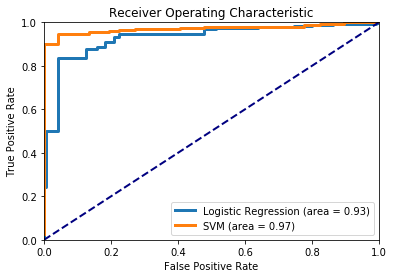

In [3]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
#fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
#roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

plt.figure()
plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'])
plt.plot(fpr['svm'], tpr['svm'], lw=3, label='SVM (area = %0.2f)' % roc_auc['svm'])
#plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('10x_Combined_ROC.eps')
plt.show()